In [325]:
from pyntcloud import PyntCloud 
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
import pandas as pd
import os
import sys
import pdb
from pcdiff import knn_graph

In [326]:
def Edge_and_Plane(path, edge_k = 20, plane_overlap = 6, edge_thresh = 0.06, plane_deviation = 1e-3, min_planesize = 10):
    # Load the XYZ file as a DataFrame
    df = pd.read_csv(path, sep=" ", usecols=[0, 1, 2], names=["x", "y", "z"])
    df["row_index"] = df.index
    # Convert DataFrame to a PyntCloud object
    pc = PyntCloud(df)
    x = pc.points['x'].values.reshape(-1,1)
    y = pc.points['y'].values.reshape(-1,1)
    z = pc.points['z'].values.reshape(-1,1)
    pc_array = np.hstack((x,y,z))

    tree = pc.add_structure("kdtree")
    nbh_curv = pc.get_neighbors(k=edge_k, kdtree=tree) 
    eigenField = pc.add_scalar_field("eigen_values", k_neighbors=nbh_curv)
    curvfield = pc.add_scalar_field("curvature", ev = eigenField)
    curvature = pc.points['curvature('+str(edge_k+1)+')'].values

    plane_size = min_planesize
    while plane_size >= min_planesize:
        plane_field = pc.add_scalar_field("plane_fit", max_dist=plane_deviation, max_iterations=500)
        plane = pc.points['is_plane'].values.reshape(-1,1)
        plane_size = np.sum(plane[:,0], axis=0)
        
        if plane_size >= min_planesize:
            row_indicies = pc.points['row_index'].values.reshape(-1,1)
            plane_col = np.zeros_like(x)
            plane_col[row_indicies[np.where(plane == 1)[0]]] = 1
            pc_array = np.hstack((pc_array,plane_col))
            pc.points = pc.points[pc.points['is_plane'] != 1]

    if pc_array.shape[1] == 3:
        pc_array = np.hstack((pc_array, np.zeros_like(x).reshape(-1,1)))

    nbh_plane = knn_graph(pc_array[:,0:3], plane_overlap)
    __, col_plane = nbh_plane
    num_planes = len(pc_array[0,3:])
    plane_count = np.count_nonzero(np.sum(pc_array[col_plane,3:].reshape(-1,plane_overlap,num_planes), axis=1), axis=1)
    edge_index = np.where((plane_count > 1) | (curvature >= edge_thresh))[0]
    edges = np.zeros_like(x)
    edges[edge_index,0] = 1

    plane_index = np.where((plane_count == 1) & (edges[:,0] != 1))[0]
    planes = np.zeros_like(x)
    planes[plane_index,0] = 1
    return edges, planes

In [327]:
def Scalar_fields(path, k = 50):
    df = pd.read_csv(path, sep=" ", usecols=[0, 1, 2], names=["x", "y", "z"])
    df["row_index"] = df.index
    pc = PyntCloud(df)
    x = pc.points['x'].values.reshape(-1,1)
    y = pc.points['y'].values.reshape(-1,1)
    z = pc.points['z'].values.reshape(-1,1)
    pc_array = np.hstack((x,y,z))

    tree = pc.add_structure("kdtree")
    nbh_curv = pc.get_neighbors(k=k, kdtree=tree)

    eigenField = pc.add_scalar_field("eigen_values", k_neighbors=nbh_curv)

    curvfield = pc.add_scalar_field("curvature", ev = eigenField)
    curvature = pc.points['curvature('+str(k+1)+')'].values.reshape(-1,1)

    linfield = pc.add_scalar_field("linearity", ev = eigenField)
    linearity = pc.points['linearity('+str(k+1)+')'].values.reshape(-1,1)

    planfield = pc.add_scalar_field("planarity", ev = eigenField)
    planarity = pc.points['planarity('+str(k+1)+')'].values.reshape(-1,1)

    spherefield = pc.add_scalar_field("sphericity", ev = eigenField)
    sphericity = pc.points['sphericity('+str(k+1)+')'].values.reshape(-1,1)

    omnivarfield = pc.add_scalar_field("omnivariance", ev = eigenField)
    omnivaraiance = pc.points['omnivariance('+str(k+1)+')'].values.reshape(-1,1)

    eigentropyfield = pc.add_scalar_field("eigenentropy", ev = eigenField)
    eigentropy = pc.points['eigenentropy('+str(k+1)+')'].values.reshape(-1,1)

    anisofield = pc.add_scalar_field("anisotropy", ev = eigenField)
    anisotropy = pc.points['anisotropy('+str(k+1)+')'].values.reshape(-1,1)

    eigensum_field = pc.add_scalar_field("eigen_sum", ev = eigenField)
    eigensum = pc.points['eigen_sum('+str(k+1)+')'].values.reshape(-1,1)

    return curvature, linearity, planarity, sphericity, omnivaraiance, eigentropy, anisotropy, eigensum


In [328]:
def Get_variables(path, k=50, edge_k=20, edge_thresh=0.06, plane_overlap=6, plot="No", save="yes"):
    curvature, linearity, planarity, sphericity, omnivaraiance, eigentropy, anisotropy, eigensum = Scalar_fields(path, k=k)
    edge, plane = Edge_and_Plane(path, edge_k=edge_k, plane_overlap=plane_overlap, edge_thresh=edge_thresh)
    xyz = np.loadtxt(path)

    PC_variables = np.hstack((xyz, edge, plane, curvature, linearity, planarity, sphericity, omnivaraiance, eigentropy, anisotropy, eigensum))

    if save == "yes":
        np.savetxt("./detected_edge/PC_variables.xyz", PC_variables, fmt="%.6f", delimiter=" ")

    if plot == "yes":
        # edge
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=edge, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='edge')

        plt.show()

        # plane
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=plane, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Plane')

        plt.show()

        # curvature
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=curvature, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Curvature')

        plt.show()

        #Linearity
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=linearity, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Linearity')

        plt.show()

        #Planarity
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=planarity, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Planarity')

        plt.show()

        #Sphericity
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=sphericity, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Sphericity')

        plt.show()

        #Omnivariance
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=omnivaraiance, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Omnivariance')

        plt.show()

        #Eigentropy
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=eigentropy, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Eigentropy')

        plt.show()

        #Anisotropy
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=anisotropy, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Anisotropy')

        plt.show()

        #Eigensum
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xyz = np.loadtxt(path)

        scatter = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2],
                            c=eigensum, cmap='viridis')

        fig.colorbar(scatter, ax=ax, label='Eigensum')

        plt.show()
    
    return PC_variables


c:\Users\aagaa\anaconda3\envs\rd\Lib\site-packages\pyntcloud\scalar_fields\eigenvalues.py:50: RuntimeWarning: divide by zero encountered in log
  result += ev[:, i] * np.log(ev[:, i])
c:\Users\aagaa\anaconda3\envs\rd\Lib\site-packages\pyntcloud\scalar_fields\eigenvalues.py:50: RuntimeWarning: invalid value encountered in multiply
  result += ev[:, i] * np.log(ev[:, i])
c:\Users\aagaa\anaconda3\envs\rd\Lib\site-packages\pyntcloud\scalar_fields\base.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.pyntcloud.points[k] = v


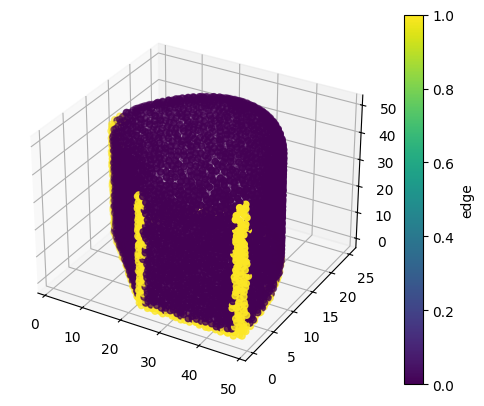

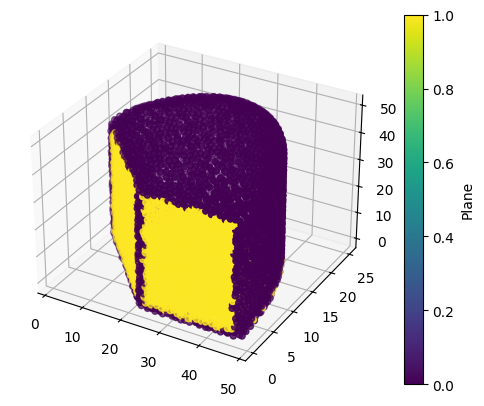

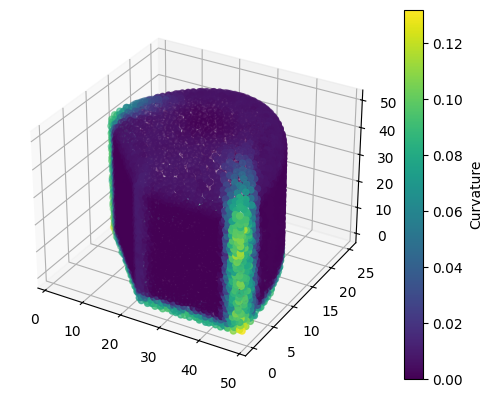

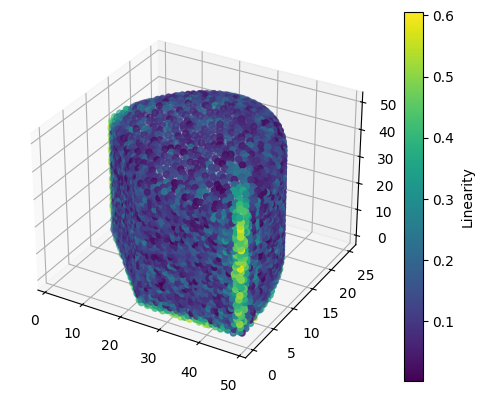

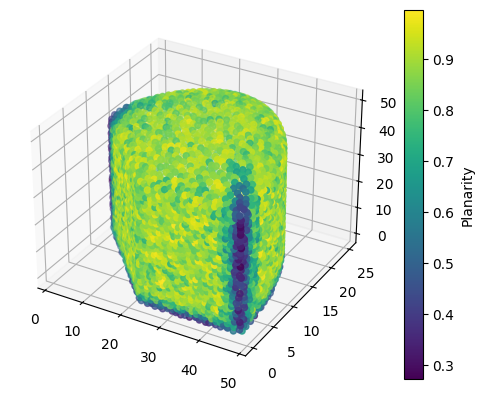

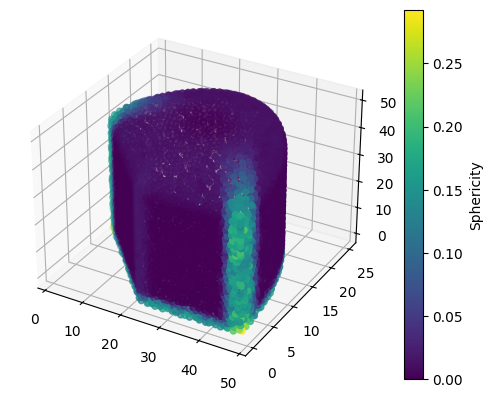

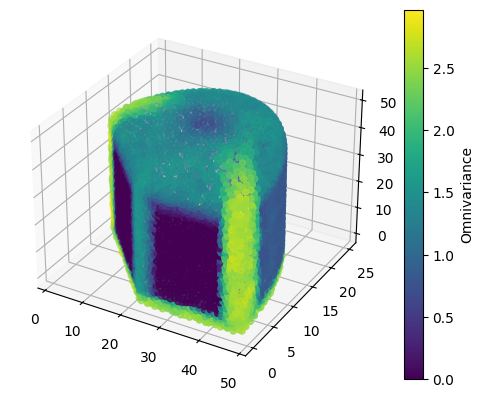

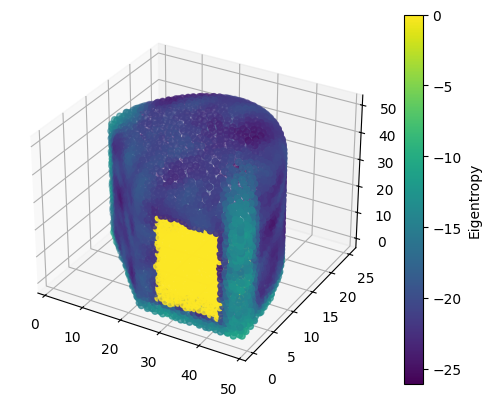

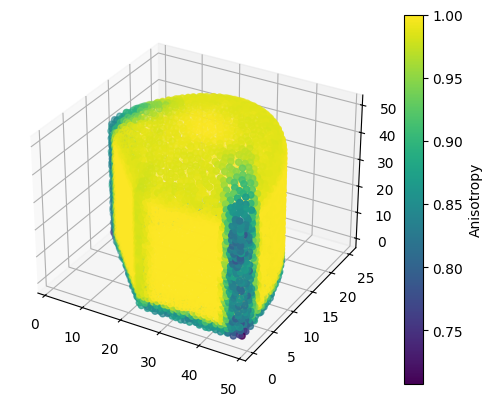

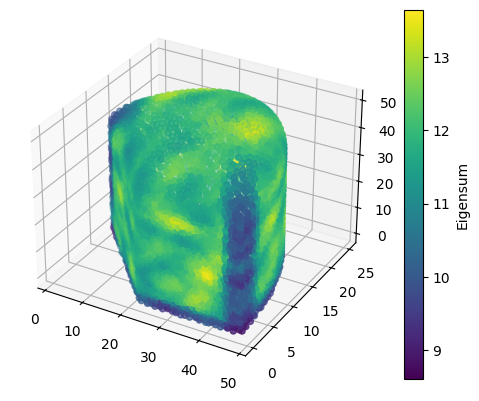

array([[ 42.237115  ,  16.05342   ,   5.180298  , ..., -20.92818076,
          0.99768812,  11.81205533],
       [ 32.480852  ,   1.102115  ,  44.56289   , ..., -20.38339999,
          0.98593153,  11.74347819],
       [ 32.797938  ,   0.        ,  28.703356  , ...,   0.        ,
          1.        ,  11.46841054],
       ...,
       [ 17.790908  ,  18.264542  ,  49.135378  , ..., -20.44308183,
          0.98841239,  11.74114648],
       [ 46.647002  ,   8.40798   ,  39.387116  , ..., -22.82881785,
          0.99674284,  12.51128154],
       [ 21.171455  ,  24.911361  ,  30.542296  , ..., -20.60411843,
          0.99778514,  11.70910403]])

In [337]:
path = "C:/Users/aagaa/Documents/GitHub/R-D/Drawings/STL/test.xyz"

Get_variables(path, plot="yes")